<a href="https://colab.research.google.com/github/elliottabe/RF_Workshop/blob/main/Workshop_notebook.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Installing repo and dependencies if using colab. Skip to imports if running locally
!pip install -U matplotlib &> /dev/null
!git clone https://github.com/elliottabe/RF_workshop.git &> /dev/null
!pip install -r ./pytorchGLM/requirements.txt &> /dev/null
!pip install git+https://github.com/elliottabe/RF_workshop.git &> /dev/null

# Import modules

In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
import io_dict_to_hdf5 as ioh5

##### Plotting settings ######
import matplotlib as mpl

mpl.rcParams.update({'font.size':         10,
                     'axes.linewidth':    2,
                     'xtick.major.size':  3,
                     'xtick.major.width': 2,
                     'ytick.major.size':  3,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'pdf.fonttype':      42,
                     'xtick.labelsize':   10,
                     'ytick.labelsize':   10,
                     'figure.facecolor': 'white'

                    })


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'torch'

In [11]:
data = ioh5.load('/home/eabe/Research/Data/FMephys/ModelData_all.h5')

In [13]:
data['070921_J553RT']['hfwn']

dict_keys(['model_eyerad', 'model_nsp', 'model_phi', 'model_t', 'model_th', 'model_vid_sm', 'unit_nums'])

In [16]:
model_nsp = data['070921_J553RT']['hfwn']['model_nsp']
model_vid_sm = data['070921_J553RT']['hfwn']['model_vid_sm']

In [22]:
model_nsp.shape, model_vid_sm.shape

((18773, 128), (18773, 30, 40))

# Data prep

In [18]:
from sklearn.model_selection import train_test_split, GroupShuffleSplit

In [33]:
NKfold = 1
test_train_size = 0.8
frac = 0.1
gss = GroupShuffleSplit(n_splits=NKfold, train_size=test_train_size, random_state=42)
nT = model_nsp.shape[0]
groups = np.hstack([i*np.ones(int((frac*i)*nT) - int((frac*(i-1))*nT)) for i in range(1,int(1/frac)+1)])

train_idx_list=[]
test_idx_list = []
for train_idx, test_idx in gss.split(np.arange(nT), groups=groups):
    train_idx_list.append(train_idx)
    test_idx_list.append(test_idx)
    
    
train_idx = train_idx_list[0]
test_idx = test_idx_list[0]
xtrain = model_vid_sm[train_idx].reshape(len(train_idx),-1)
ytrain = model_nsp[train_idx]
xtest = model_vid_sm[test_idx].reshape(len(test_idx),-1)
ytest = model_nsp[test_idx]
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((15019, 1200), (15019, 128), (3754, 1200), (3754, 128))

In [34]:
xtr, xte, ytr, yte = torch.from_numpy(xtrain).float().to(device), torch.from_numpy(xtest).float().to(device), torch.from_numpy(ytrain).float().to(device), torch.from_numpy(ytest).float().to(device)

In [48]:
input_size = xtr.shape[1]
output_size = ytr.shape[1]
Num_units = model_nsp.shape[1]

In [69]:
model = nn.Sequential(nn.Linear(input_size,output_size),
                      nn.ReLU()).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=25)

In [61]:
np.logspace(-2, 3,num=20),np.logspace(-2, 3,num=20)[13]

(array([1.00000000e-02, 1.83298071e-02, 3.35981829e-02, 6.15848211e-02,
        1.12883789e-01, 2.06913808e-01, 3.79269019e-01, 6.95192796e-01,
        1.27427499e+00, 2.33572147e+00, 4.28133240e+00, 7.84759970e+00,
        1.43844989e+01, 2.63665090e+01, 4.83293024e+01, 8.85866790e+01,
        1.62377674e+02, 2.97635144e+02, 5.45559478e+02, 1.00000000e+03]),
 26.366508987303583)

In [62]:
for epoch in range(5000):
    model.train()
    optimizer.zero_grad()
    yhat = model(xtr)
    loss = nn.MSELoss()(yhat, ytr)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss {loss.item()}')

Epoch 0, Loss 0.7199630737304688
Epoch 100, Loss 0.5656185746192932
Epoch 200, Loss 0.5548007488250732
Epoch 300, Loss 0.5521941184997559
Epoch 400, Loss 0.5507671236991882
Epoch 500, Loss 0.5496734976768494
Epoch 600, Loss 0.548879861831665
Epoch 700, Loss 0.5480968952178955
Epoch 800, Loss 0.5474640727043152
Epoch 900, Loss 0.5469987392425537
Epoch 1000, Loss 0.5466261506080627
Epoch 1100, Loss 0.5462659597396851
Epoch 1200, Loss 0.5459455251693726
Epoch 1300, Loss 0.5456585884094238
Epoch 1400, Loss 0.5453281402587891
Epoch 1500, Loss 0.5449000000953674
Epoch 1600, Loss 0.5444926023483276
Epoch 1700, Loss 0.5441246032714844
Epoch 1800, Loss 0.5437043309211731
Epoch 1900, Loss 0.543046236038208
Epoch 2000, Loss 0.5426819920539856
Epoch 2100, Loss 0.5425036549568176


KeyboardInterrupt: 

In [63]:
rfs = model[0].weight.detach().cpu().numpy().reshape(Num_units,model_vid_sm.shape[1],model_vid_sm.shape[2])

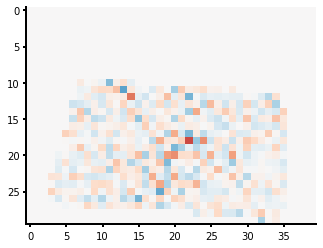

In [68]:
plt.imshow(rfs[1],cmap='RdBu_r',vmin=-np.abs(rfs[1]).max(),vmax=np.abs(rfs[1]).max())